In [9]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
v031.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [10]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0029/t1_pre_in.nc
Loading ../data/NAFLD/0029/t1_pre_water.nc
Loading ../data/NAFLD/0029/t1_pre_out.nc
Loading ../data/NAFLD/0029/t1_pre_fat.nc
Loading ../data/NAFLD/0029/t2.nc
Loading ../data/NAFLD/0029/mre_raw.nc
Loading ../data/NAFLD/0029/wave.nc
Loading ../data/NAFLD/0029/mre.nc
Loading ../data/NAFLD/0029/anat_mask.nc
Loading ../data/NAFLD/0029/mre_mask.nc
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


<IPython.core.display.Javascript object>


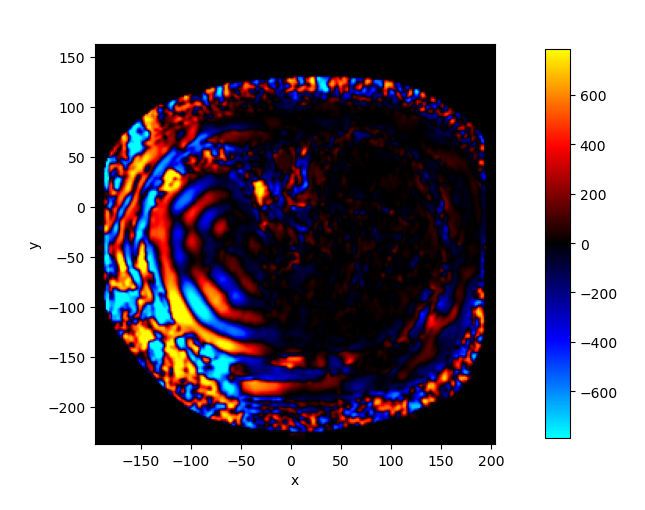

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [176]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0029'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
#cohort.eval_baseline()
cohort[0].view(['wave'])

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



<IPython.core.display.Javascript object>


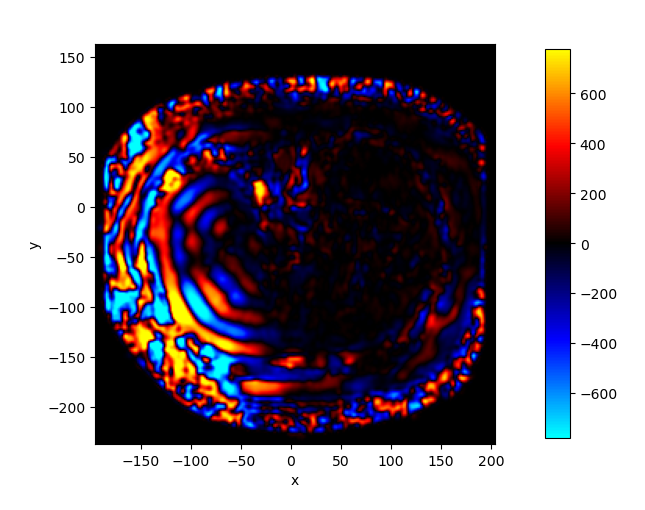

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


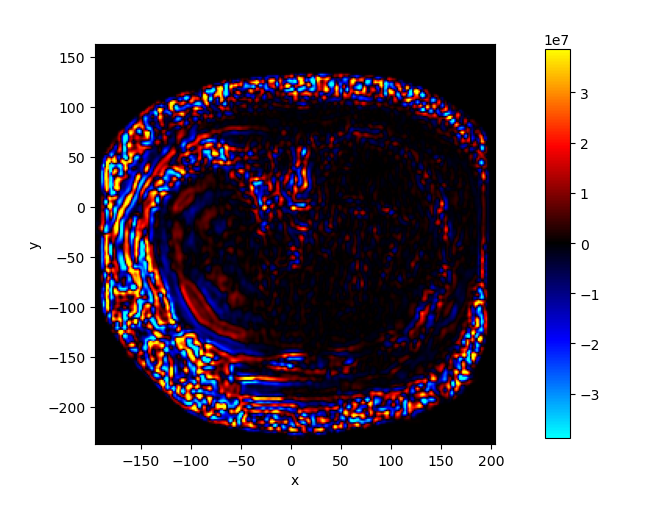

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


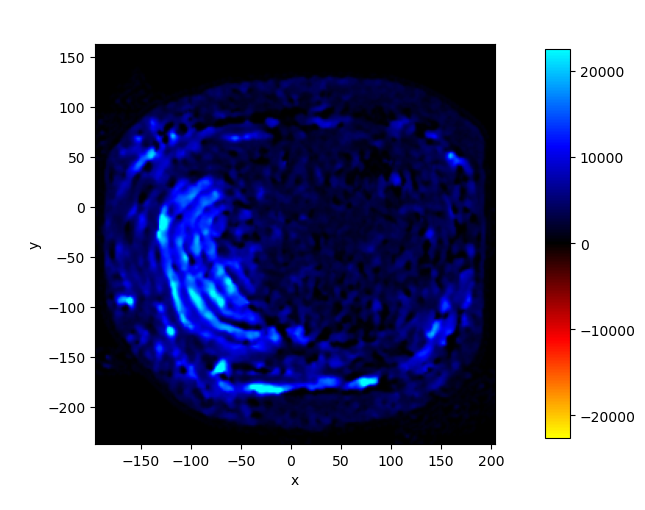

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


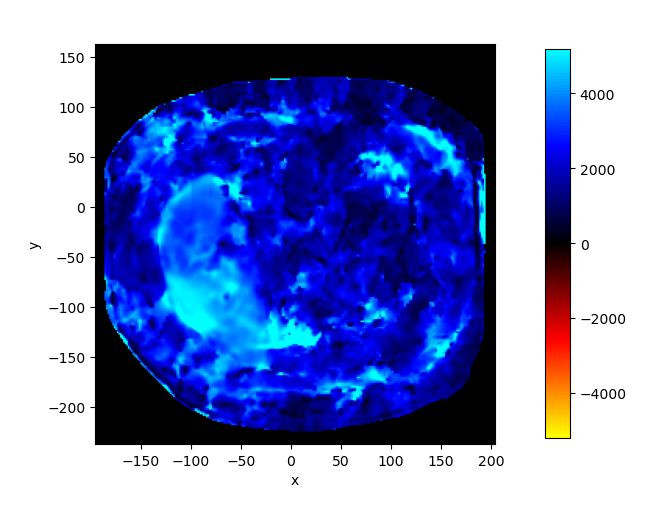

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [177]:
%autoreload
cohort[0].eval_baseline(order=3, kernel_size=5)
cohort[0].view(['Kwave', 'Lwave', 'Mwave', 'mre'])

In [178]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [6]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=2,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_spatial_freqs=128,
    u_omega=10/300,
    u_scale=1e2,
    mu_omega=10/300,
    mu_scale=5e2,
    skip_connect=True,
    dense=True,
    debug=True
)
pino

input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128


HyperCNN(
  (cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
   

In [7]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e0, 0, 1e-8],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000439 s



In [ ]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model.train(100000, display_every=10, callbacks=[test_eval])

Training model...

